# Project 2

## Topic : Stereo reconstruction and Non-linear optimization

#### Instructions
<ul>
    <li> The second project of the course is designed to get you familiar with stereo reconstruction, and non-linear optimization </li>
    <li> Use python for this project. PILLOW and OpenCV are permitted for image I/O. </li>
    <li> Submit this notebook as a zipped file on moodle. The format should be $<$team_id$>$_$<$team_ name$>$.zip. Both members have to submit this zip file. </li>
    <li> A seperate report is not needed if you're coding in the notebook itself. Please provide adequate descriptions of the approaches you've taken. Also mention work distribution for the two members. </li>
    <li> Refer to the late day policy. Start early </li> 
    <li> Download data from here: https://iiitaphyd-my.sharepoint.com/:f:/g/personal/aryan_sakaria_students_iiit_ac_in/Er5C7351IAlFsvwHUesFeSQBQtlSiAS7AORSEJT2qH_8_w?e=ol98k9  </li>
</ul>

# Work Distribution:

- Part A, 1: Ahish & Jaidev
- Part A, 2: Ahish
- Part B: Jaidev

----
### PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo camerasprovide  us  with  a  convenient  way  to  generate  dense  point  clouds.Densehere,  in  contrast  tosparse,means all the image points are used for the reconstruction.  In this part of the assignment you will begenerating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Notethat the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds from each disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the providedground truth poses. </li>
    <li> Visualize the registered point cloud data, in color.  Use Open3D for this </li>
</ol>
    

In [1]:
%matplotlib inline

#import libraries:
import numpy as np 
# from sklearn.preprocessing import normalize #normalizing gives better results. Experiment with this
import cv2
import open3d as o3d

# Additional Imports
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

plt.rcParams["figure.figsize"] = (20,3)

In [2]:
def read_transformations(filename='./mr2020_project_data/poses.txt'):
    f = open(filename, 'r')
    lines = f.readlines()
    transformation_list = []
    for i in range(len(lines)):
        transformation_list_temp = lines[i].split()
        temp_rot = [] 
        temp_rot.append( (transformation_list_temp[0:4]) ) 
        temp_rot.append( (transformation_list_temp[4:8]) ) 
        temp_rot.append( (transformation_list_temp[8:12]) ) 
        transformation_list.append(temp_rot)
    return transformation_list

In [3]:
def read_calibrations(path="./mr2020_project_data/calib.txt"):
    
    with open(path, 'r') as f:
        lines = f.readlines()
    
    K = []
    baseline = 0
    K_flag, B_flag = 0, 0
    
    for line in lines:
        line = line.rstrip("\n")
        
        if K_flag:
            vals = list(map(lambda x : float(x), line.split()))
            K = np.array(vals).reshape(3,3)
            K_flag = 0
        if B_flag:
            baseline = float(line.split()[0])
        
        if "K" in line:
            K_flag = 1
        if "baseline" in line:
            B_flag = 1
            
    return K, baseline

Since we may be dealing with a very large dataset, we create a dataloader object similar to that in PyTorch to access our stereo pairs. The dataloader will fetch the images as and when required. The iterator object is defined purely to allow iterating over the dataloader.

In [4]:
# Iterator object that works with the StereoData class
class StereoIterator:
    
    def __init__(self, StereoData):
        self.data = StereoData
        self.index = 0
        self.files = os.listdir(self.data.path1)
        
    def __len__(self):
        return len(self.files)
        
    def __next__(self):
        
        self.index += 1

        if (self.index - 1) >= len(self.files):
            raise StopIteration
        
        return (cv2.imread(os.path.join(self.data.path1, self.files[self.index-1])), 
                           cv2.imread(os.path.join(self.data.path2, self.files[self.index-1])))

"""

This class represents a dataloader for stereo pair images. 
It accepts the paths to the image folders for the left and right images respectively.
We use openCV to read the images.
   
"""
class StereoData:
    
    def __init__(self, path1, path2):
        
        self.path1 = path1
        self.path2 = path2
        self.files = sorted(os.listdir(self.path1))
        
    def __len__(self):
        return len(self.files)
    
    def __str__(self):
        return f"{len(self.files)} pairs of L-R images"
    
    def __iter__(self):
        return StereoIterator(self)
    
    def __getitem__(self, k):
                
        if k < 0:
            k = len(self) - k
        elif k > len(self):
            raise ValueError("Index out of bounds")
        
        return (cv2.imread(os.path.join(self.path1, self.files[k])), 
                   cv2.imread(os.path.join(self.path2, self.files[k])))

In [5]:
"""

Helper function to visualize the stereo pairs as well as the disparity image.

Inputs:
- img1: Image
- img2: Image
- img3 (optional): Image
- disparity (optional): boolean, if set to True indicates that img2 is the disparity map
- debug (optional): boolean, prints the parameters for disparity map calculation

"""
def show_images(img1, img2, img3=None, disparity=False, debug=False, num_disparity=0, val=0, uniquenessRatio=0):

    if not disparity:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle(f"{i}th Stereo Pair")
        ax1.imshow(img1)
        ax2.imshow(img2)
        plt.show()
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        
        if debug:
            fig.suptitle(f"Stereo Pair #{i} with {num_disparity} num_disparity, {val} blockSize, {uniquenessRatio} uniquenessRatio")
        else:
            fig.suptitle(f"Stereo Pair #{i}")
        
        ax1.imshow(img1)
        ax2.imshow(img3, cmap="gray")
        ax3.imshow(img2)
        plt.show()

In [6]:
data = StereoData("./mr2020_project_data/img2", "./mr2020_project_data/img3")
K, baseline = read_calibrations()
T = np.array(read_transformations())

In the below cell, we define an interactive function to help tune our disparity map parameters. Since StereoSGBM has several parameters with a wide range, using this interactive slider helps view trends easily. However, we choose our final set of parameters based on the point cloud generated - which cannot be done live due to the significant time taken.

In [7]:
i = 0
img1, img2 = data[0]

# Use the sliders in the 
@interact(numDisparities=(16, 256, 16), minDisparity=16, blockSize=(5, 255, 2), uniquenessRatio=11, speckleRange=32, 
          speckleWindowSize=100, disp12MaxDiff=1, window_size=3)
def onChange(numDisparities, minDisparity, blockSize, uniquenessRatio, speckleRange, speckleWindowSize,
             disp12MaxDiff, window_size):
   
    stereo = cv2.StereoSGBM_create(numDisparities=numDisparities, 
                                 minDisparity=minDisparity,
                                 blockSize=blockSize,
                                 uniquenessRatio=uniquenessRatio,
                                 speckleWindowSize=speckleWindowSize,
                                 speckleRange=speckleRange,
                                 disp12MaxDiff=disp12MaxDiff,
                                 P1=8*3*window_size**2,
                                 P2=32*2*window_size**2
                                )
    
    imgL = img1.copy()
    imgR = img2.copy()
    
    imgL = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    imgR = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    disparity = stereo.compute(imgL, imgR)
    
    show_images(img1, img2, disparity, True, True, numDisparities, blockSize, uniquenessRatio)

interactive(children=(IntSlider(value=128, description='numDisparities', max=256, min=16, step=16), IntSlider(…

In [13]:
numDisparities=112
blockSize=1
uniquenessRatio=11
speckleRange=32
window_size=3
minDisparity=16
disp12MaxDiff=1
speckleWindowSize=100

We use StereoSGBM to compute the disparity maps, and performed better than StereoBM. This is likely because SGBM looks for a semi global optimum. 

In [14]:
stereo = cv2.StereoSGBM_create(numDisparities=numDisparities, 
                           minDisparity=minDisparity,
                             blockSize=blockSize,
                             uniquenessRatio=uniquenessRatio,
                             speckleWindowSize=speckleWindowSize,
                             speckleRange=speckleRange,
                             disp12MaxDiff=disp12MaxDiff,
                             P1=8*3*window_size**2,
                             P2=32*2*window_size**2
                            )

We divide our disparity images by 64, a multiple of 16 to fit the requirement for `reprojectImageTo3D`. We choose 64 since it gave us the best results visually.

In [15]:
def get_disparity(img_l, img_r, stereo):
    return stereo.compute(img_l,img_r)/64

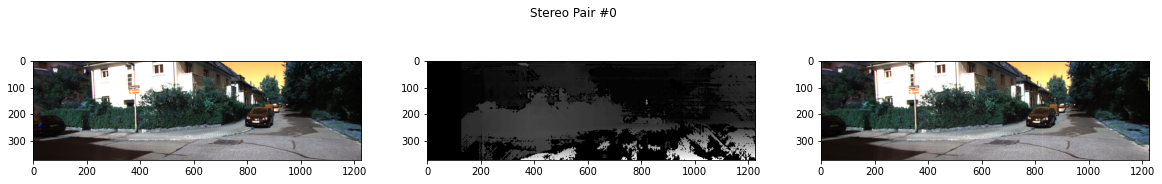

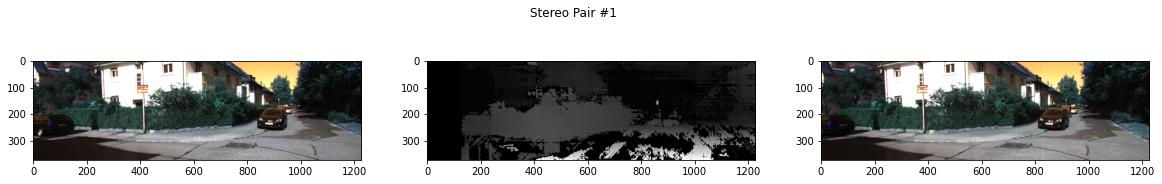

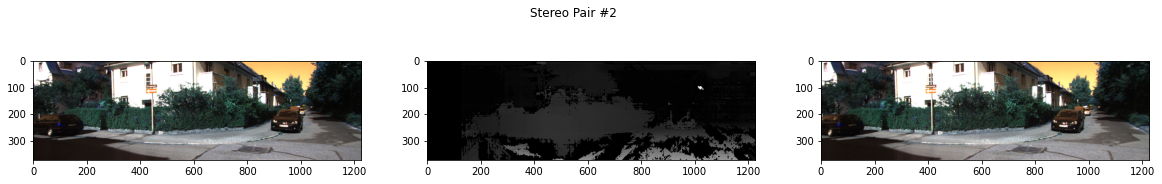

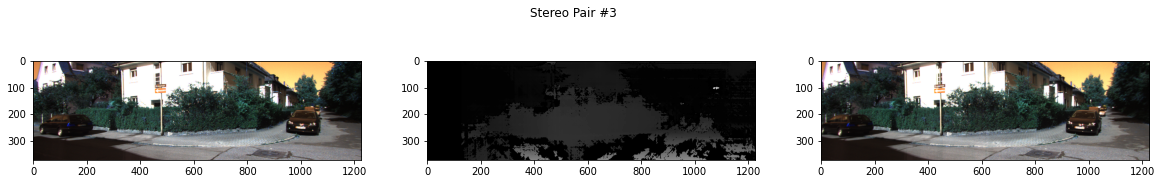

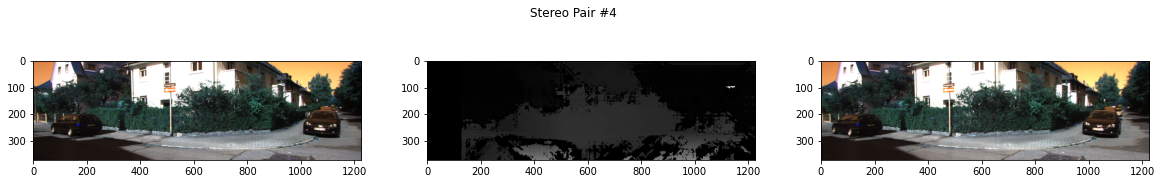

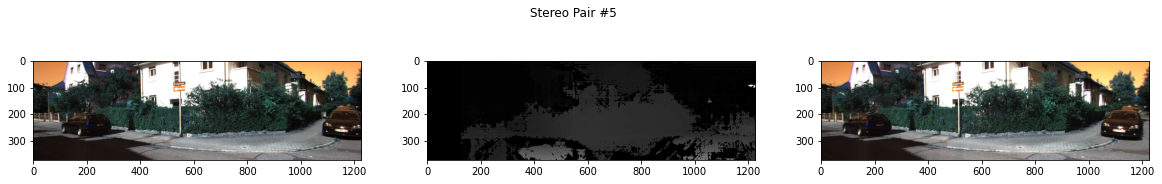

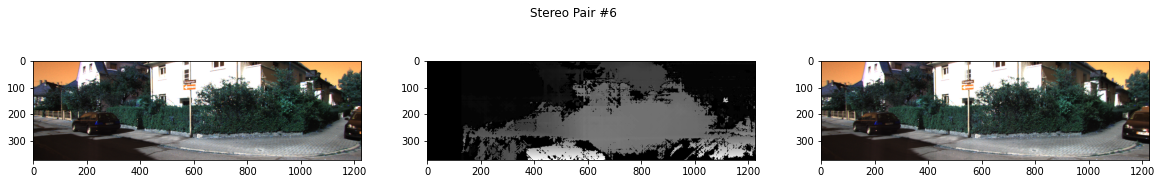

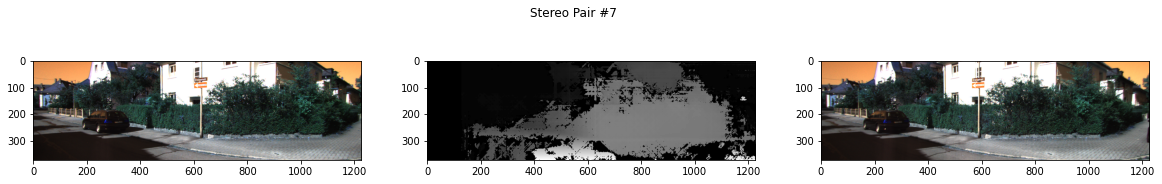

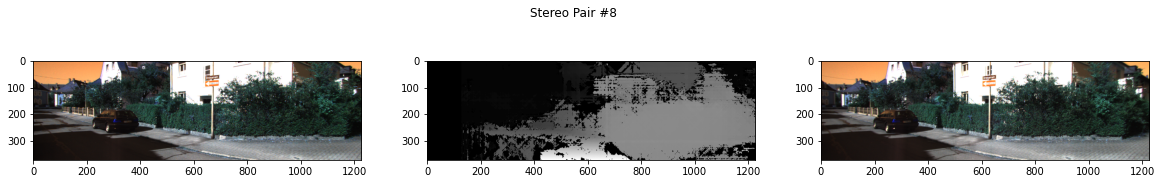

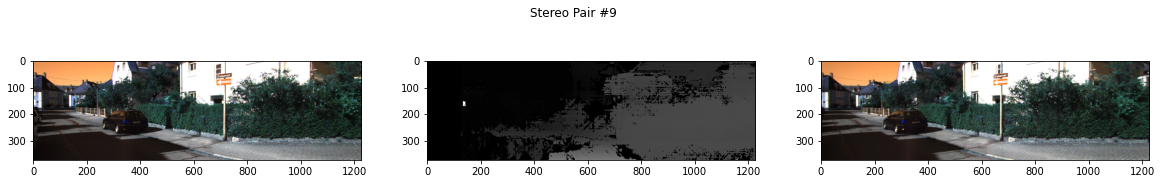

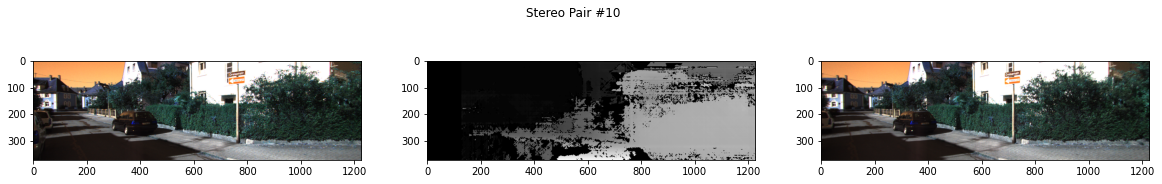

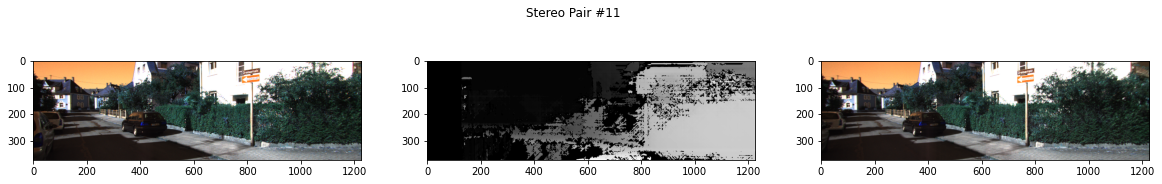

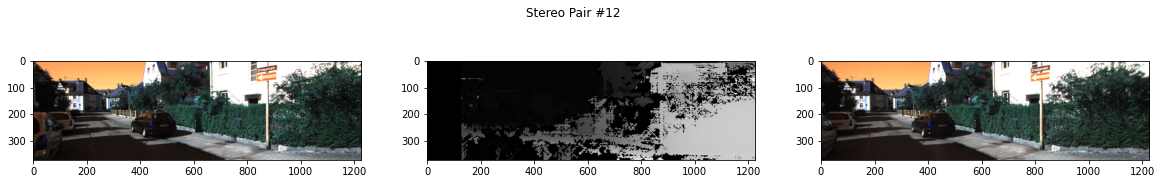

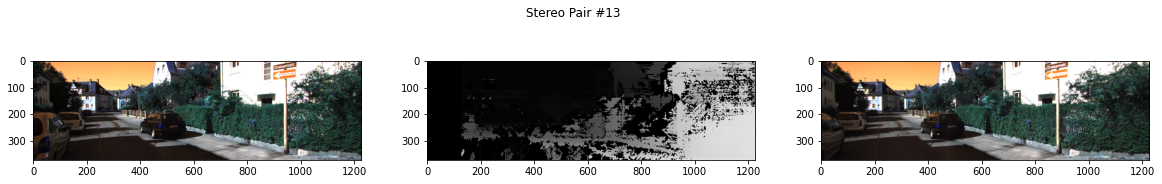

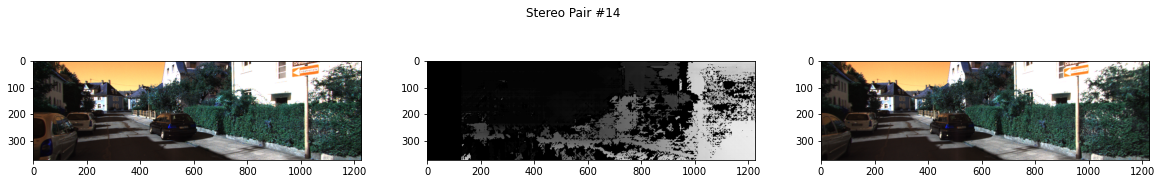

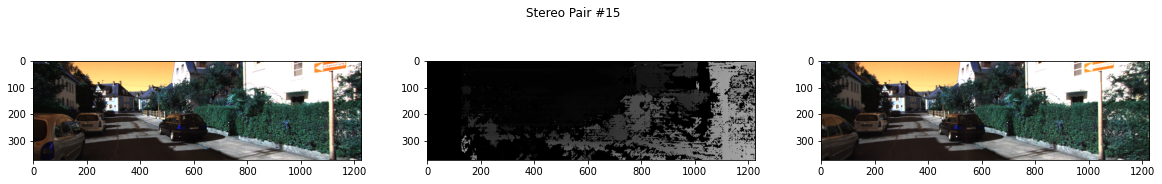

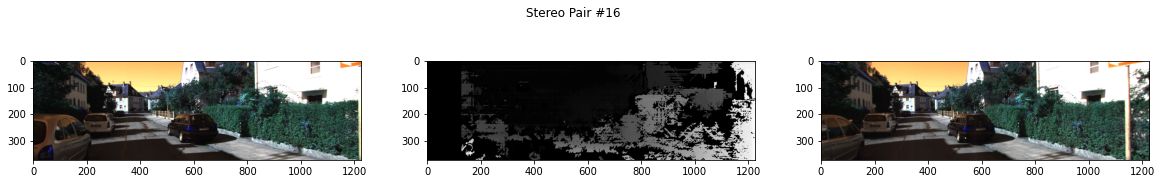

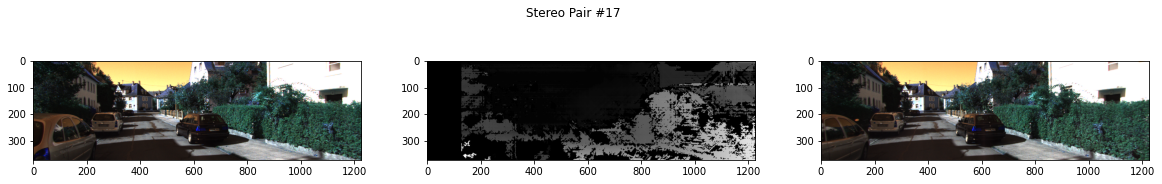

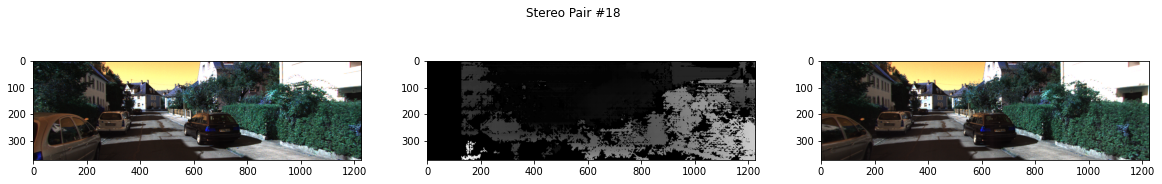

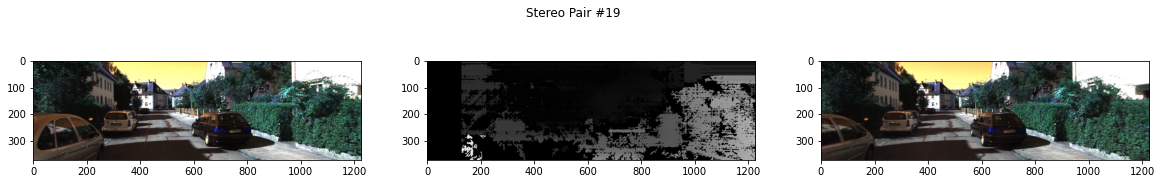

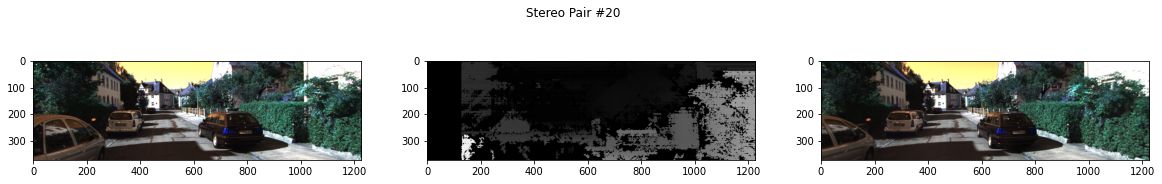

In [16]:
disparities = []

for i, (imgL, imgR) in enumerate(data):
    
    img1 = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    
    disparity = get_disparity(img1, img2, stereo)
    disparities.append(disparity)
    
    show_images(imgL, imgR, disparity, True, False)

The Q matrix encodes information about the focal length, image center and the baseline of the system. We pass this as a parameter to the `reprojectImageTo3D` function. The final depth is calculated using the standard formula $z = \frac{fb}{d}$, but the Q matrix allows for a compact mapping from $x -> X$ where $x$ is the image point with disparity. 
    
$Q\begin{bmatrix}u \\ v \\ d \\ 1\end{bmatrix} = \begin{bmatrix}X \\ Y \\ Z \\ 1\end{bmatrix}$

In [17]:
def generate_q(K, baseline, img):
    
    f = K[0][0]
    h, w = img.shape[:2]
    
    Q = np.zeros((4,4), dtype='float64')
    Q[0,0], Q[1,1] = 1, -1
    Q[0,-1], Q[1,-1], Q[2,-1] = -w/2, h/2, -f
    Q[-1,2] = 1./baseline
    
    return Q    

The following cell generates the Q matrix for each image, computes the disparity map, reprojects the image to 3D and generates the point cloud. Then, we display colour by adding RGB data from the left image (arbitrary choice). Since we want to visualize all the point clouds together, we also  transform to the world frame using the poses given to us.

Note: Due to inconsistencies with the depth, the combined point clouds aren't very perfect. To alleviate this problem, we use point to plane ICP between the new point cloud and old set of points. We notice minor improvements with this but the execution time significantly increases. The flag `do_ICP` can enable this.

In [30]:
world_points = []
reg = []
do_ICP = False

for i, (imgL, imgR) in enumerate(data):
    
    if i % 5 == 0 or i == 20:
        print(f"{i*100/20}% done")

    # Generate the Q matrix
    Q = generate_q(K, baseline, data[i][0])
    
    # Generate the 3D points using camera intrinsics and disparity map
    points = cv2.reprojectImageTo3D(disparities[i].astype('int32'), Q, False)   
    imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
    
    # Select only those points with a reasonable disparity
    thres = 4
    points = points[disparities[i] > thres]
    imgL_cut = imgL[disparities[i] > thres]
    
    # Colour taken from left image - RGB tuples
    pcl_points = points.reshape(-1, 3) 
    colors = imgL_cut.reshape(-1, 3) / 255
            
    R = T[i][:,:3].astype('float64')
    t = T[i][:,3].astype('float64')
    
    pcl_points = pcl_points @ R + t
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pcl_points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
        
    world_points.append(pcd)
    
    # Point to plane ICP
    if do_ICP:
        if i == 0:
            pcd.estimate_normals()
            reg = pcd
        else:
            pcd.estimate_normals()
            trans = np.eye(4)
            source = pcd
            target = reg
            reg_st = o3d.registration.registration_icp(
                source, target, 0.1, trans,
                o3d.registration.TransformationEstimationPointToPlane()
            )
            
            source.transform(reg_st.transformation)
            reg = source + target            
            
# Downsample for smoother visualization
for i in range(len(world_points)):
    world_points[i] = world_points[i].voxel_down_sample(voxel_size=0.05)

0.0% done
25.0% done
50.0% done
75.0% done
100.0% done


In [27]:
if do_ICP:
    o3d.visualization.draw_geometries([reg])
else:
    vis = o3d.visualization.Visualizer()
    vis.create_window()

    for i in world_points:
        vis.add_geometry(i)

    ctr = vis.get_view_control()
    parameters = o3d.io.read_pinhole_camera_parameters("ScreenCamera_2020-11-24-16-02-42.json")
    ctr.convert_from_pinhole_camera_parameters(parameters)  

    vis.run()
    vis.destroy_window()

----
### PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recoverthis pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since hereyou’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

## Configurable Parameters

In [31]:
n_pcd = 9
n_points = 30000

## Generating the Actual P Matrix

In [32]:
transforms = read_transformations()
K, _ = read_calibrations()

# Getting transform from point cloud to image
Rt_2Dto3D = np.array(transforms[n_pcd], dtype="float32")
Rt_3Dto2D = np.eye(4)
Rt_3Dto2D[:3,:4] = Rt_2Dto3D
Rt_3Dto2D = (np.linalg.inv(Rt_3Dto2D))[:3,:]

P = K @ Rt_3Dto2D
print(f"Expected P matrix:\n{P}")

Expected P matrix:
[[-6.93561342e+02  3.40715663e+01 -6.16488457e+02 -9.94920681e+04]
 [ 1.32903982e+01  7.13813655e+02 -1.54275025e+02  8.82455379e+03]
 [ 2.20918260e-02  4.02124956e-02 -9.98946892e-01  5.38841122e+01]]


## Generating the 2D-3D Correspondences

Getting non downsampled point cloud

In [33]:
world_points_for_correspondences = []

for i, (imgL, imgR) in enumerate(data):
    
    if i % 5 == 0 or i == 20:
        print(f"{i*100/20}% done")
    
    Q = generate_q(K, baseline, data[i][0])
    
    points = cv2.reprojectImageTo3D(disparities[i].astype('int32'), Q, False)   
    imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)

    pcl_points = points.reshape(-1, 3) 
    colors = imgL.reshape(-1, 3) / 255
            
    R = T[i][:,:3].astype('float64')
    t = T[i][:,3].astype('float64')
    
    pcl_points = pcl_points @ R + t
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pcl_points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
        
    world_points_for_correspondences.append(pcd)

0.0% done
25.0% done
50.0% done
75.0% done
100.0% done


Randomly choosing points and finding their 2D correspondences from the selected point cloud,

In [34]:
pcd_points = np.asarray(world_points_for_correspondences[n_pcd].points)
pcd_colors = np.asarray(world_points_for_correspondences[n_pcd].colors)
choices = np.random.randint(0, len(pcd_points)-1, n_points)
# X = pcd_points[choices]
X = pcd_points
cols = pcd_colors
print(X.shape)
print(cols.shape)

(453620, 3)
(453620, 3)


In [35]:
# getting the homogenous 3D points X
X_hom = np.ones((len(X), 4))
X_hom[:,:3] = X

# getting the homogenous 2D points x
x_hom = (P @ X_hom.T).T
x_hom /= x_hom[:,2].reshape(-1,1)

## Jacobian Calculation

We know the residual is,
$$
r = x_{2D} - P_kX_{3D}
$$

Let $X_{3D}$ represent $[X_i, Y_i, Z_i, 1]$ for simplicity.

On expanding, we get,

$$
r = \begin{bmatrix}
x_i \\
y_i \\
1
\end{bmatrix} - \begin{bmatrix}
P_{11} & P_{12} & P_{13} & P_{14} \\
P_{21} & P_{22} & P_{23} & P_{24} \\
P_{31} & P_{32} & P_{33} & P_{34} \\
\end{bmatrix} \begin{bmatrix}
X_i \\ 
Y_i \\
Z_i \\
1
\end{bmatrix}
$$

On expanding the term on the right further, we get

$$
\begin{bmatrix}
A^T \\
B^T \\
C^T \\
\end{bmatrix} \begin{bmatrix}
X_i \\ 
Y_i \\
Z_i \\
1 \\
\end{bmatrix} = \begin{bmatrix}
P_{11}X_i + P_{12}Y_i + P_{13}Z_i + P_{14} \\
P_{21}X_i + P_{22}Y_i + P_{23}Z_i + P_{24} \\
P_{31}X_i + P_{32}Y_i + P_{33}X_i + P_{34} \\
\end{bmatrix}
$$ where, 

$$
A=\begin{bmatrix} P_{11} & P_{12} & P_{13} & P_{14} \end{bmatrix} \\
B=\begin{bmatrix} P_{21} & P_{22} & P_{23} & P_{24} \end{bmatrix} \\
C=\begin{bmatrix} P_{31} & P_{32} & P_{33} & P_{34} \end{bmatrix}
$$

Now, to normalize, we divide throughout by $C^TX_i$.



Thus for a particular $X_{3D}, [X_i, Y_i, Z_i]$, on partial differentiation, we get the Jacobian for each sample to be of the form,
$$
\begin{bmatrix}
-\frac{X_i}{C^TX_{3D}} & -\frac{Y_i}{C^TX_{3D}} & -\frac{Z_i}{C^TX_{3D}} & -\frac{1}{C^TX_{3D}} & 0 & 0 & 0 & 0 & \frac{X_iA^TX_{3D}}{(C^TX_{3D})^2} & \frac{Y_iA^TX_{3D}}{(C^TX_{3D})^2} & \frac{Z_iA^TX_{3D}}{(C^TX_{3D})^2} & \frac{1}{(C^TX_{3D})^2} \\
0 & 0 & 0 & 0 & -\frac{X_i}{C^TX_{3D}} & -\frac{Y_i}{C^TX_{3D}} & -\frac{Z_i}{C^TX_{3D}} & -\frac{1}{C^TX_{3D}} & \frac{X_iB^TX_{3D}}{(C^TX_{3D})^2} & \frac{Y_iB^TX_{3D}}{(C^TX_{3D})^2} & \frac{Z_iB^TX_{3D}}{(C^TX_{3D})^2} & \frac{1}{(C^TX_{3D})^2} \\
\end{bmatrix}
$$

In [21]:
def get_jacobian(x, X, Pk):
    
    J = np.zeros((2*len(x), 12))
    
    x_pred = (Pk @ X.T).T
    Z = x_pred[:,2]
    
    # Update for xi
    J[::2, 0] = -X[:,0] / Z
    J[::2, 1] = -X[:,1] / Z 
    J[::2, 2] = -X[:,2] / Z
    J[::2, 3] = -1 / Z
    J[::2, 8] = X[:,0] * x_pred[:,0] / (Z**2)
    J[::2, 9] = X[:,1] * x_pred[:,0] / (Z**2) 
    J[::2,10] = X[:,2] * x_pred[:,0] / (Z**2) 
    J[::2,11] = 1 / (Z**2)
    
    # Update for yi
    J[1::2, 4] = -X[:,0] / Z
    J[1::2, 5] = -X[:,1] / Z
    J[1::2, 6] = -X[:,2] / Z
    J[1::2, 7] = -1 / Z
    J[1::2, 8] = X[:,0] * x_pred[:,1] / (Z**2)
    J[1::2, 9] = X[:,1] * x_pred[:,1] / (Z**2)
    J[1::2,10] = X[:,2] * x_pred[:,1] / (Z**2)
    J[1::2,11] = 1 / (Z**2)

    return J
    
def gauss_newton(x, X, P0, n_iters = 20, lmbda = 10):
    
    Pk = P0.copy()
    errors = []
    
    for k in range(n_iters):
        
        # current projection calculation
        x_pred = (Pk @ X.T).T
        x_pred = x_pred / x_pred[:,2].reshape(-1,1)

        # residual calculation
        r = x - x_pred

        # error calculation
        err = np.sum(r**2)
        errors += [err]
        print(f"Error at iteration {k+1} = {err}")

        # Jacobian Calculation
        J = get_jacobian(x, X, Pk)
        
        # removing the difference in Z (since it's normalized)
        r_trunc = r[:,:2].flatten().reshape(-1,1)
        
        # Gauss Newton
        fac = np.linalg.pinv(J.T @ J)
#         fac = np.linalg.pinv(J.T @ J + lmbda*np.eye(12)) # LM Algo
        dPk = fac @ (J.T @ r_trunc)
        
        # updating P
        Pk -= dPk.reshape(3,4)
    
    plt.plot(range(1,len(errors)+1), errors)
    plt.title("Error vs Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.show()
    
    return Pk, errors


## Varying Initial Estimates

### Estimate 1

Adding random noise,

In [22]:
P0 = P + 100*np.random.random()
P0 = np.array([
    [-6.55197885e+02,  7.24350234e+01, -5.78125000e+02, -9.94537046e+04],
    [ 5.16538553e+01,  7.52177112e+02, -1.15911568e+02,  8.86291725e+03],
    [ 3.83855490e+01,  3.84036696e+01,  3.73645102e+01,  9.22475693e+01]
])
print(P0)

[[-6.55197885e+02  7.24350234e+01 -5.78125000e+02 -9.94537046e+04]
 [ 5.16538553e+01  7.52177112e+02 -1.15911568e+02  8.86291725e+03]
 [ 3.83855490e+01  3.84036696e+01  3.73645102e+01  9.22475693e+01]]


Error at iteration 1 = 1.358290149069e+17
Error at iteration 2 = 3.962333154682156e+16
Error at iteration 3 = 1.2867157990911242e+16
Error at iteration 4 = 690505376934750.0
Error at iteration 5 = 4646859316689271.0
Error at iteration 6 = 446828397047691.9
Error at iteration 7 = 7631968765649876.0
Error at iteration 8 = 409857512554835.75
Error at iteration 9 = 7265903517311998.0
Error at iteration 10 = 333406745070378.9


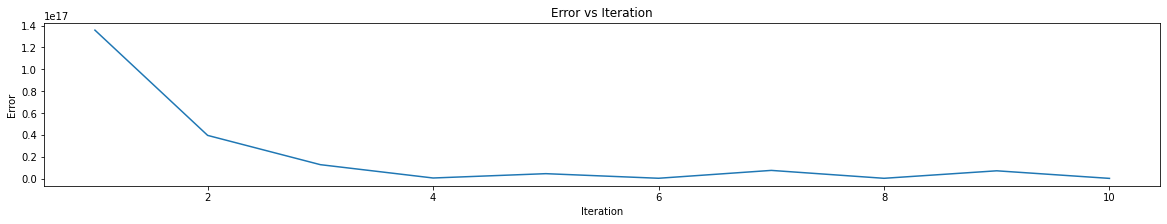


Optimized estimate of P:
[[-9.29473139e+02  8.72691437e+01 -3.18677367e+02 -9.94519257e+04]
 [-5.29146563e+00  7.60958089e+02 -6.76612168e+01  8.86324966e+03]
 [ 3.83291497e+01  3.83307990e+01  3.73079892e+01  1.55857528e+02]]

Difference from ground truth P:
[[-235.91179756   53.19757744  297.81109005   40.14238201]
 [ -18.58186384   47.14443344   86.61380805   38.6958633 ]
 [  38.30705782   38.29058648   38.30693605  101.97341621]]


In [23]:
P_opt, errors = gauss_newton(x_hom, X_hom, P0, 10)

print(f"\nOptimized estimate of P:\n{P_opt}")
print(f"\nDifference from ground truth P:\n{P_opt - P}")

#### Reconstruction from obtained P

In [24]:
reconstructed_points = (P_opt @ X_hom.T).T

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(reconstructed_points)
pcd.colors = o3d.utility.Vector3dVector(cols)

o3d.visualization.draw_geometries([pcd])

### Estimate 2

Randomly scaling,

In [25]:
P0 = P/np.random.random((3,4))
P0 = np.array([
    [-5.19862645e+04,  6.24034449e+01, -7.41802299e+02, -1.33853434e+06],
    [ 7.04942248e+01,  1.25181981e+03, -4.91224709e+02,  9.52647153e+03],
    [ 2.21133651e-01,  9.58119079e-02, -4.13146439e+00,  1.04018054e+02]
])
print(P0)

[[-5.19862645e+04  6.24034449e+01 -7.41802299e+02 -1.33853434e+06]
 [ 7.04942248e+01  1.25181981e+03 -4.91224709e+02  9.52647153e+03]
 [ 2.21133651e-01  9.58119079e-02 -4.13146439e+00  1.04018054e+02]]


Error at iteration 1 = 228669833754657.56
Error at iteration 2 = 305543092837626.4
Error at iteration 3 = 15513191846350.17
Error at iteration 4 = 1269838606341.6965
Error at iteration 5 = 83819726688.04552
Error at iteration 6 = 57199674845.87791
Error at iteration 7 = 813301972.6777924
Error at iteration 8 = 269079959.8820271
Error at iteration 9 = 254491197.13029101
Error at iteration 10 = 240433402.58892724
Error at iteration 11 = 230860839.95254028
Error at iteration 12 = 226353479.83177742
Error at iteration 13 = 224166347.2399013
Error at iteration 14 = 223051697.4589176
Error at iteration 15 = 222456361.54228953


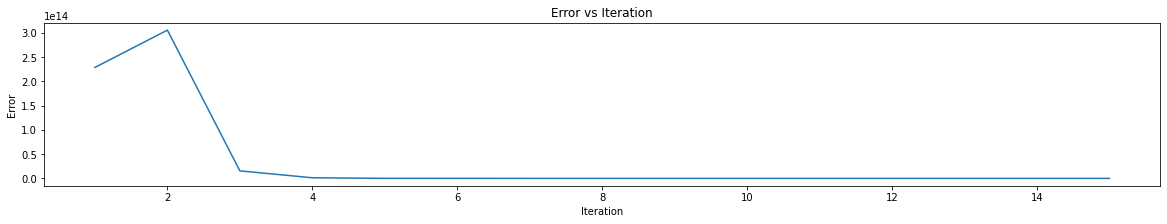


Optimized estimate of P:
[[-8.39580351e+03 -3.70062292e+02 -5.80477391e+03 -1.33564959e+06]
 [-1.75208721e+02  7.38828843e+03 -1.28793796e+03 -5.09940491e+03]
 [-1.66308339e+00 -5.27554297e-01 -8.70414531e+00  5.74586160e+00]]


In [26]:
P_opt, errors = gauss_newton(x_hom, X_hom, P0, 15)

print(f"\nOptimized estimate of P:\n{P_opt}")

#### Reconstruction from obtained P

In [27]:
reconstructed_points = (P_opt @ X_hom.T).T

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(reconstructed_points)
pcd.colors = o3d.utility.Vector3dVector(cols)

o3d.visualization.draw_geometries([pcd])

### Estimate 3

Initializing with all values almost 0,

In [28]:
P0 = np.random.random((3,4))/1e5
P0 = np.array([
    [6.98900627e-07, 1.59534721e-06, 4.37324802e-06, 6.08385013e-06],
    [9.44099448e-06, 8.98456199e-06, 7.81798348e-06, 7.99557082e-06],
    [6.77872245e-06, 5.05016332e-06, 2.99112948e-06, 7.57709766e-06]
])
print(P0)

[[6.98900627e-07 1.59534721e-06 4.37324802e-06 6.08385013e-06]
 [9.44099448e-06 8.98456199e-06 7.81798348e-06 7.99557082e-06]
 [6.77872245e-06 5.05016332e-06 2.99112948e-06 7.57709766e-06]]


Error at iteration 1 = 1022394626619.6971
Error at iteration 2 = 460302116898.351
Error at iteration 3 = 268755962339.16895
Error at iteration 4 = 263871306321.30203
Error at iteration 5 = 263640780918.22342
Error at iteration 6 = 263464816857.6088
Error at iteration 7 = 263507386021.32205
Error at iteration 8 = 263536359288.09952
Error at iteration 9 = 263954121989.2871
Error at iteration 10 = 264035952219.95123


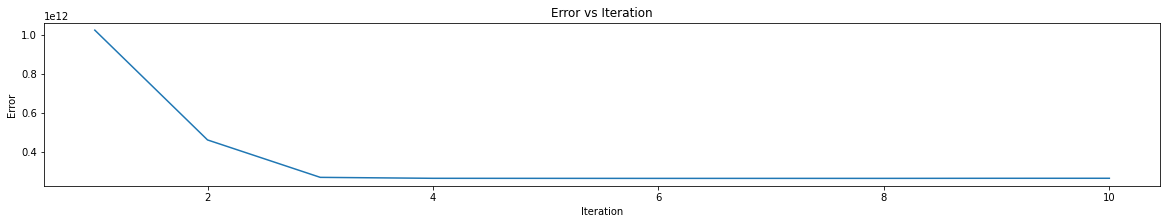


Optimized estimate of P:
[[ 6.87490754e-06 -6.16714432e-06  3.52542935e-06  6.08148190e-06]
 [ 1.26692867e-05  5.89377624e-06  5.79768431e-06  7.98494267e-06]
 [ 6.20591512e-06  4.62360101e-06  2.73480953e-06  7.57709678e-06]]

Difference from ground truth P:
[[ 6.93561349e+02 -3.40715724e+01  6.16488461e+02  9.94920681e+04]
 [-1.32903855e+01 -7.13813649e+02  1.54275031e+02 -8.82455379e+03]
 [-2.20856201e-02 -4.02078720e-02  9.98949627e-01 -5.38841046e+01]]


In [29]:
P_opt, errors = gauss_newton(x_hom, X_hom, P0, 10)

print(f"\nOptimized estimate of P:\n{P_opt}")
print(f"\nDifference from ground truth P:\n{P_opt - P}")

#### Reconstruction from Obtained P

In [30]:
reconstructed_points = (P_opt @ X_hom.T).T

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(reconstructed_points)
pcd.colors = o3d.utility.Vector3dVector(cols)

o3d.visualization.draw_geometries([pcd])

# Project 2: Part B

# Project 2 - Part B:

## 1. SfM pipeline (`6 mark`)

To get the context of below questions, take a look at the code above: The same questions have been asked at different places above as comments in the code.

1. `0.5 mark` **Basics** - How do we know this (`camera_ind`) information in practical setting? In other words, how do we know observations in `points_2d` belong to which camera. Explain. 
    - Ans-1 - Basics:
    In a practical setting, we can associate each picture with a camera pose. Hence, there is a pair correspondence for picture and camera pose. Since the points stored in `points_2d` come from the image, we can extend this correspondence to the image coordinates. These images are typically taken from a feature extractor such as SIFT.
    
    
2. `0.5 mark` **Basics** - How do we know this (`point_ind`) information in practical setting?  In other words, how do we know observations in `points_2d` belong to which 3D point. Explain.
    - Ans-2 - Basics: 
    We typically initialize the 3D point cloud using triangulation from a pair of images. Hence, for every 3D point, we have a pair of 2D points. Since we have a mapping from image -> 2D points (just a filtering operation on `camera_ind`, we can easily find the point indices for these points. We can then use the relevant points to estimate the relative transformation and perform triangulation. Since there are multiple image points (across various views) that can correspond to the same 3D point, we can store an array of image points per 3D point. Now, creating the array `points_2d` is a simple operation of ordering all 3D points, and iterating through their corresponding array values to assign that 3D point index to the particular 2D point.
    
    
3. `0.5 mark` **Transformations** - `project()` function: In the `project()` function, would it make any difference if I do translate first, then rotate? Why/why not?
    - Ans-3 - Transformations: If we do a translation first, our transformation will look like: $R(X + t) = RX + Rt$. However, this is not the motion model that we expect to follow
        
        
4. `0.5 mark` **Jacobian** - `bundle_adjustment_sparsity()` function: m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    - Ans-4 - Jacobian: M\*N is the upper bound on the number of points for M 3D points from N views. In practice, we may not capture all M objects/real world points from each view. Hence, our actual value of `n_observation` is lower than M\*N.
    
    
5. `2 mark` **Jacobian & Parameters** - `bundle_adjustment_sparsity()` function: 
    1.  Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`? Recollect: Every individual motion Jacobian was (1*)12 in our lecture notes. 
        - Ans 5.1 - Jacobian & Parameters: Here the parameters we are optimizing are the translation vector (3 params), rotation vector (3 params using axis-angle representation), focal length (1 param), and distortion (2 parameters). In total, we have 9 paramaters for each camera here.
   
    2. Ignoring the scale parameters, what was the number of unknown parameters in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in the code? Is it different? If so, what is and why? [Link of notes](https://www.notion.so/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470).
        - Ans 5.2 - Jacobian & Parameters: As per the lecture, the number of unknown parameters are `(n_cameras * 12) + (n_points * 3)`. Here we have `n_camera` views which are represented by $3\times 4$ projection matrices. This projection matrix is equivalent to $K[R|t] = P$. Hence, there are 12 parameters in total. In the code, we have `(n_cameras * 9) + (n_points * 3)` - reasoning in the previous answer. In the code we are not solving for P directly, but rather $t$, $R$, and components of $K$.
       
       - Note that we originall start with 6 parameters for our motion model since we already know our intrinsics. However, since we want to optimize over the manifold and the entire projection matrix, we are forced to use the entire matrix.
            
            
6. `2 mark` **Sparsity, Residual Vector & Jacobian** - `bundle_adjustment_sparsity()` function: Explain what you understand from above 6 lines of code by coding a simple toy example yourself to illustrate how it is different from what you've learnt in class. ([Coding toy example + elaborating in words]- both are compulsory.)
    - Ans 6 - Sparsity, Residual Vector & Jacobian: We can understand the structure of the jacobian and hence the 6 lines of codes with the following:
    
    1. The Jacobian is being computed with respect to 9 motion parameters, and 3 structure parameters. These are laid out as the columns of the jacobian.
    2. Since we have `n_cameras`, there are `n_cameras*9` columns for motion. Further, for `n_points`, there are `n_points*3` columns for structure.
    3. Just as with the lecture notes, the first set of columns correspond to motion, and the latter part is for structure. Hence, to index the columns of jacobian, we move to the corresponding camera by `camera_ind * 9` and to the corresponding point by `camera_ind * 9 + points_ind * 3`. Once we have reached the corresponding section, the `for` loop updates the individual elements of the projection and 3D world point.
    4. The rows of the jacobian correspond to each point that we have observed (we have `n_points`). Since each point has an $x$ and $y$ coordinate, we have 2 rows for each image point. We use even rows for $x$ and odd rows for $y$, hence the `2*i` and `2*i + 1` indexing for the rows of the jacobian.
       
       The previous answers have already explained the intuition for 9 motion and 3 structure points. That difference between the lecture and code is reflected in our Jacobian formulation as well. The construction of the Jacobian is very similar to the illustration in the notes as well, and we show this with an example.
       
Let us take a set of 3 world points, captured through 3 cameras. Hence, we have a set of 3\*3 image points. We generate the `camera_indices` and `point_indices`using this information and maintain an ordering like in class along the rows, we group all camera views together, and consider the points in order. We explore this in more detail after the code block.

<b> The following code block WILL NOT run since it belongs to the main bundle adjustment code. It will run there though. </b>

In [ ]:
import sys

n_points = 3
n_cameras = 3

np.set_printoptions(threshold=sys.maxsize)

camera_indices = np.array([j for j in range(n_cameras) for i in range(n_points) ])
print("Camera index for each image point:", camera_indices)
point_indices = np.array([np.arange(n_points) for i in range(n_cameras)]).flatten()
print("3D World point index for each image point:", point_indices)

A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
print("Jacobian matrix:\n\n", A.toarray())


Our output looks like:

<pre>
Camera index for each image point: [0 0 0 1 1 1 2 2 2]
3D World point index for each image point: [0 1 2 0 1 2 0 1 2]
Jacobian matrix:

 [[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1]]
</pre>

As evident from the matrix seen above - this Jacobian closely resembles the one seen in class. Notice how the first two rows of the matrix can be seen as:

$J_{11m_{1\times 9}}\; 0_{1\times 9}\; 0_{1\times 9}\; J_{11s_{1\times 3}}\; 0_{1\times 3}\; 0_{1\times 3}$

$G_{11m_{1\times 9}}\; 0_{1\times 9}\; 0_{1\times 9}\; G_{11s_{1\times 3}}\; 0_{1\times 3}\; 0_{1\times 3}$

These two rows correspond to the first point seen in the first camera frame. Since each point is seen in this camera frame, there are three such pair of rows. Or, there are $2*N$ rows for each camera view.

Further, each point is visible in EVERY frame, hence the structure of the next $2*N$ rows are similar, but just offset by 9 columns to represent the 2nd camera.

#### Difference with the previous example

Unlike our toy example, each world point was not seen in each frame. Further, the ordering of the points may not be structured like ours. Hence, the jacobian will look different. Similarly, the residual may also be out of order in terms of camera indices and world points.

## 2. Initializing R,t and 3D points for SfM given 2 images (`4 mark`)

Using OpenCV functions, mention how you would initialize R,t (poses) and 3D points for SfM given 2 images and K matrix. You don't need to implement it, just mention function names with input/output arguments clearly and briefly explain what they do (You don't need to give detailed answers). A sample answer could be as follows:

**Ans 2:**

1. First, we do feature matching using the following function

    `Matcher_Object.match()`: It takes 2 descriptors of the two images as input arguments and gives us the best matches/correspondences as outputs. These outputs are passed to the next step. *The matcher object can be something like the brute-force matcher object, and must be instantiated before this function call*. *The feature descriptors can be obtained using SIFT, ORB or similar.*

2. Once we have our matches, we must extract the essential matrix using `cv.findEssentialMat` which takes the image correspondences as two separate inputs along with the camera matrix and outputs the essential matrix. The essential matrix is approximated using the five-point algorithm.

3. Now that we have essential matrix, we can decompose it into R,t as following:

    `Rt = cv2.recoverPose(E, pts0, pts1, K)`: This takes Essential matrix, K matrix and the corresponding points in 2 images as input arguments and gives us R,t. `Rt[1]` would give us R and `Rt[2]` would give us t.

4. Now that we have the transformation between the two images, we find 3D points as follows:
    - Calculate the projection matrix for the second image as $K[R|t]$.
    - Call the function `cv2.triangulatePoints` with inputs $K$ and $K[R|t]$ as projection matrices of first and second camera, and the feature points obtained in step 1 as the third and fourth arguments. The function then outputs the 3D points in homogenous coordinates.